# Generación de meta-tópicos

## Carga de librerías

In [47]:
from ast import literal_eval
from bertopic import BERTopic
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import trustworthiness
from sklearn.preprocessing import FunctionTransformer
from wordcloud import WordCloud
from tqdm import tqdm

import numpy as np
import pandas as pd
import stopwordsiso as stopwords
import pickle
import matplotlib.pyplot as plt

## Funciones

In [4]:
def compute_trustworthiness(X_high, X_low, k_eval=10, metric_high="cosine", sample=None, random_state=42):
    N = X_high.shape[0]
    idx = np.arange(N)
    if sample is not None and sample < N:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(N, size=sample, replace=False)
    Xh = X_high[idx]
    Xl = X_low[idx]
    tw = trustworthiness(Xh, Xl, n_neighbors=k_eval, metric=metric_high)
    return float(tw)

In [5]:
def sweep_persistence_median(
    X,
    min_cluster_sizes,
    *,
    min_samples_frac=None,
    hdbscan_cls=None,
    hdbscan_kwargs=None,
    random_state=42
):
    """
    Barre min_cluster_size y calcula la mediana de persistencia de los clusters.
    
    Devuelve un DataFrame con columnas:
    - min_cluster_size
    - median_persistence
    - n_clusters
    """
    if hdbscan_kwargs is None:
        hdbscan_kwargs = {}

    # elegir clase HDBSCAN si no se pasa
    if hdbscan_cls is None:
        try:
            from cuml.cluster import HDBSCAN as cuHDB
            hdbscan_cls = cuHDB
        except Exception:
            from hdbscan import HDBSCAN as cpuHDB
            hdbscan_cls = cpuHDB

    rows = []

    for mcs in min_cluster_sizes:
        print(f"min_cluster_size = {mcs}")
        params = dict(hdbscan_kwargs)
        params["min_cluster_size"] = int(mcs)
        if min_samples_frac is not None:
            params["min_samples"] = max(1, int(np.floor(mcs * float(min_samples_frac))))

        clusterer = hdbscan_cls(**params).fit(X)

        pers = getattr(clusterer, "cluster_persistence_", None)

        # convertir a numpy si hace falta
        try:
            import cupy as cp
            if isinstance(pers, cp.ndarray):
                pers = cp.asnumpy(pers)
        except Exception:
            pass
        if hasattr(pers, "to_pandas"):  # cudf.Series
            pers = pers.to_pandas().values

        pers = np.asarray(pers).ravel() if pers is not None else np.array([])

        median_pers = float(np.median(pers)) if pers.size else np.nan
        n_clusters = pers.size

        rows.append({
            "min_cluster_size": mcs,
            "median_persistence": median_pers,
            "n_clusters": n_clusters
        })

    df = pd.DataFrame(rows)
    return df


def plot_persistence_line(df, x="min_cluster_size", y="median_persistence"):
    """
    Lineplot de persistencia mediana frente a min_cluster_size.
    """
    plt.figure(figsize=(8,4.5))
    plt.plot(df[x], df[y], marker="o")
    plt.xlabel("min_cluster_size")
    plt.ylabel("Mediana de persistencia")
    plt.title("Persistencia vs min_cluster_size")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Carga y transformación de datos

In [6]:
data_path = "../data/topics.csv"

In [7]:
df_topics = pd.read_csv(data_path)
df_topics.head().iloc[:, 1:]

,tid,n_messages,description,keywords,representative_docs,theme
0,0,111,0_vacunamos_novavax_fauci_reacciones,"['vacunamos', 'novavax', 'fauci', 'reacciones'...",['estracto de la agencia europea del medicamen...,Conspiracy theories and misinformation about C...
1,1,106,1_encontrado_oficialialistas_mujer_desconectado,"['encontrado', 'oficialialistas', 'mujer', 'de...","['los viajes espaciales, la creacion de una pa...",The theme revolves around conspiracy theories ...
2,2,85,2_expreso0demedianoche_directo_anonimo_descarg...,"['expreso0demedianoche', 'directo', 'anonimo',...",['el expreso de media noche directo del 24/02 ...,Unauthorized use of a popular podcast's name a...
3,3,65,3_despiertos_actuamos_inocencia_hijos,"['despiertos', 'actuamos', 'inocencia', 'hijos...",['da mucho asco ver ciertos personajes que van...,"Critique of egoism, superficiality, and lack o..."
4,4,63,4_protestas_republica_belga_cerrados,"['protestas', 'republica', 'belga', 'cerrados'...",['la gente se defiende: suiza fuerza un refere...,Public discontent and resistance against gover...


In [8]:
# Columna de strings a listas
df_topics["representative_docs"] = df_topics["representative_docs"].apply(literal_eval)

In [9]:
# Una fila por doc
cols = ["_id", "tid", "representative_docs"]
df_topics_expl = (df_topics[cols]
                  .explode("representative_docs", ignore_index=True))
df_topics_expl.head().iloc[:, 1:]

,tid,representative_docs
0,0,estracto de la agencia europea del medicamento...
1,0,""" si me vacunan: 1 . - ¿ puedo dejar de usar l..."
2,0,buenos días la ema avisa de que la segunda do...
3,1,"los viajes espaciales, la creacion de una pand..."
4,1,2011...este articulo del periodico sovereign i...


In [10]:
df_topics_expl.shape

(64842, 3)

In [11]:
# Evitar repetir el mismo doc dentro del mismo tópico en un mismo canal
df_topics_expl = (df_topics_expl
                  .drop_duplicates()
                  .reset_index(drop=True))

In [12]:
df_topics_expl.shape

(64228, 3)

## Carga de embeddings

In [14]:
with open("../data/embeddings.pkl", "rb") as f:
    E = pickle.load(f)

In [15]:
E.shape

(64228, 768)

## Topic modeling

Usaremos los documentos más representativos de los tópicos generados por BERTopic para generar meta-tópicos. Para ello, se volverá a reproducir el fujo de BERTopic, esta vez con estos documentos que pertenecen al conjunto total de canales. De este modo, se obtendrán temáticas más genéricas que las anteriores y comunes entre canales (permitiendo, así, establecer las relaciones que se buscan entre ellos).

### Elección de hiperparámetros

#### UMAP

In [16]:
# ==========
# Grid search sobre (n_components, n_neighbors)
# ==========
n_components_list = [10, 20, 50, 100]
n_neighbors_list  = [5, 15, 30, 50]

k_eval = 10       # nº vecinos usado en la métrica trustworthiness
sample = 10000    # submuestreo para hacerlo viable

results = []

for nc in n_components_list:
    for nn in n_neighbors_list:
        print(f">> UMAP n_components={nc}, n_neighbors={nn}")
        X_umap = UMAP(
            n_neighbors=nn,
            n_components=nc,
            min_dist=0.0,
            metric="cosine",
            random_state=42
        ).fit_transform(E)

        tw = compute_trustworthiness(E, X_umap, k_eval=k_eval, sample=sample)
        results.append({"n_components": nc, "n_neighbors": nn, "trustworthiness": tw})

df_grid = pd.DataFrame(results)
df_pivot = df_grid.pivot(index="n_components", columns="n_neighbors", values="trustworthiness")

>> UMAP n_components=10, n_neighbors=5
[2025-09-09 17:15:24.100] [CUML] [info] build_algo set to brute_force_knn because random_state is given
>> UMAP n_components=10, n_neighbors=15
[2025-09-09 17:15:31.969] [CUML] [info] build_algo set to brute_force_knn because random_state is given
>> UMAP n_components=10, n_neighbors=30
[2025-09-09 17:15:39.003] [CUML] [info] build_algo set to brute_force_knn because random_state is given
>> UMAP n_components=10, n_neighbors=50
[2025-09-09 17:15:46.359] [CUML] [info] build_algo set to brute_force_knn because random_state is given
>> UMAP n_components=20, n_neighbors=5
[2025-09-09 17:15:54.039] [CUML] [info] build_algo set to brute_force_knn because random_state is given
>> UMAP n_components=20, n_neighbors=15
[2025-09-09 17:16:01.156] [CUML] [info] build_algo set to brute_force_knn because random_state is given
>> UMAP n_components=20, n_neighbors=30
[2025-09-09 17:16:08.755] [CUML] [info] build_algo set to brute_force_knn because random_state is 

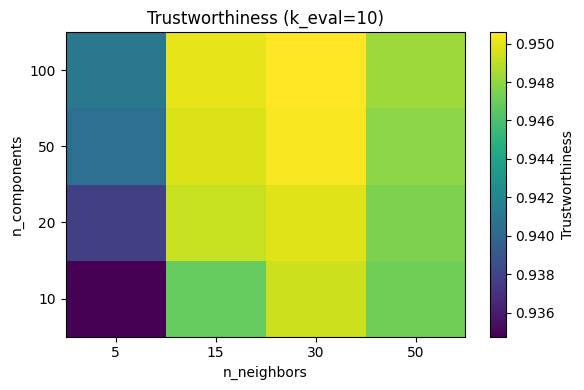

In [17]:
# Heatmap
plt.figure(figsize=(6,4))
plt.imshow(df_pivot.values, cmap="viridis", aspect="auto", origin="lower")
plt.xticks(range(len(n_neighbors_list)), n_neighbors_list)
plt.yticks(range(len(n_components_list)), n_components_list)
plt.colorbar(label="Trustworthiness")
plt.xlabel("n_neighbors")
plt.ylabel("n_components")
plt.title(f"Trustworthiness (k_eval={k_eval})")
plt.tight_layout()
plt.show()

#### HDBSCAN

In [18]:
umap_model = UMAP(n_neighbors=30, n_components=100, min_dist=0.0, metric="cosine", random_state=42)
X_umap = umap_model.fit_transform(E)

[2025-09-09 17:18:28.489] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [22]:
# GridSearch sobre min_cluster_size
grid = list(range(5, 51, 5))

df_pers = sweep_persistence_median(
    X_umap,
    grid,
    min_samples_frac=1,
    hdbscan_kwargs=dict(metric="euclidean", cluster_selection_method="eom")
)

min_cluster_size = 5
min_cluster_size = 10
min_cluster_size = 15
min_cluster_size = 20
min_cluster_size = 25
min_cluster_size = 30
min_cluster_size = 35
min_cluster_size = 40
min_cluster_size = 45
min_cluster_size = 50


In [23]:
print(df_pers)

   min_cluster_size  median_persistence  n_clusters
0                 5            0.028431        1159
1                10            0.058288         480
2                15            0.062970         304
3                20            0.076010         213
4                25            0.081127         174
5                30            0.076195         146
6                35            0.086963         124
7                40            0.089648         102
8                45            0.085112          79
9                50            0.077108          69


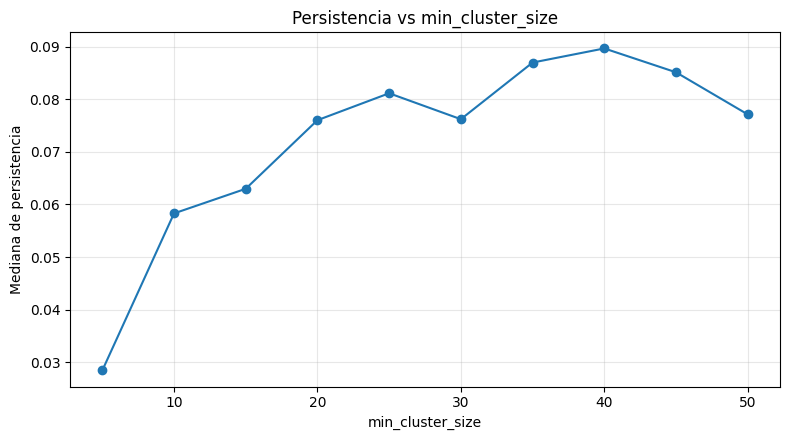

In [24]:
plot_persistence_line(df_pers)

### BERTopic

In [25]:
# Segundo BERTopic con embeddings precalculados

passthrough = FunctionTransformer(lambda X: X, validate=False)
hdbscan_model = HDBSCAN(min_cluster_size=40, metric="euclidean", prediction_data=True)

topic_model = BERTopic(
    embedding_model=None,
    umap_model=passthrough,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

meta_topics, meta_probs = topic_model.fit_transform(
    df_topics_expl["representative_docs"], embeddings=X_umap
)

2025-09-09 17:21:02,476 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-09 17:21:02,477 - BERTopic - Dimensionality - Completed ✓
2025-09-09 17:21:02,550 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-09 17:21:05,301 - BERTopic - Cluster - Completed ✓
2025-09-09 17:21:05,317 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-09 17:21:14,978 - BERTopic - Representation - Completed ✓


In [27]:
# Unir todas las stopwords de todos los idiomas en un solo set
all_stops = set().union(*(stopwords.stopwords(lang) for lang in stopwords.langs()))

# Redefinir CountVectorizer para eliminar stopwords de la representación y formar N-gramas de
# hasta 3 palabras
vectorizer_model = CountVectorizer(
    stop_words=list(all_stops),
    ngram_range=(1, 3),
    lowercase=True,
    strip_accents="unicode"
)

# Actualizar los tópicos
topic_model.update_topics(df_topics_expl["representative_docs"], vectorizer_model=vectorizer_model)

In [29]:
topic_model.visualize_topics()

In [30]:
# Visualizar los documentos clusterizados en espacio reducido a 2D
reduced_embeddings = UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric="cosine", random_state=42).fit_transform(E)
topic_model.visualize_documents(df_topics_expl["representative_docs"], reduced_embeddings=reduced_embeddings, hide_annotations=True)

[2025-09-09 17:25:17.356] [CUML] [info] build_algo set to brute_force_knn because random_state is given


## Analizar y guardar resultados

In [33]:
# Docs
docs = df_topics_expl["representative_docs"].tolist()

# Tabla por documento (alineada con 'docs')
doc_info = topic_model.get_document_info(docs)
df_topics_expl = (
    df_topics_expl.reset_index(drop=True)
    .join(
        doc_info[["Topic", "Probability"]]
        .rename(columns={"Topic": "cluster", "Probability": "cluster_prob"})
    )
)

df_topics_expl.head().iloc[:, 1:]

,tid,representative_docs,cluster,cluster_prob
0,0,estracto de la agencia europea del medicamento...,0,0.121201
1,0,""" si me vacunan: 1 . - ¿ puedo dejar de usar l...",0,0.068394
2,0,buenos días la ema avisa de que la segunda do...,0,0.092112
3,1,"los viajes espaciales, la creacion de una pand...",-1,0.522919
4,1,2011...este articulo del periodico sovereign i...,-1,0.141489


In [36]:
# Nº de canales por cluster
df_topics_expl.groupby('cluster')['_id'].nunique()

cluster
-1      398
 0      327
 1      208
 2      257
 3      238
       ... 
 97      19
 98      21
 99      26
 100     22
 101     23
Name: _id, Length: 103, dtype: int64

In [37]:
# Distribución del nº de canales por cluster (en aquellos que no son ruido)
(
    df_topics_expl[df_topics_expl["cluster"] != -1]
    .groupby("cluster")["_id"]
    .nunique()
    .describe()
)

count    102.000000
mean      56.941176
std       51.147975
min        3.000000
25%       30.000000
50%       43.000000
75%       64.750000
max      327.000000
Name: _id, dtype: float64

In [38]:
noise = len(df_topics_expl[df_topics_expl["cluster"] == -1])
noise_perc = round((noise / len(df_topics_expl) * 100), 2)
print(f"{noise_perc} % es ruido")

49.08 % es ruido


In [39]:
# Filtrar ruido (cluster == -1)
non_noise = df_topics_expl[df_topics_expl['cluster'] != -1]

# Contar tópicos distintos de ruido por canal (_id)
count_per_channel = non_noise.groupby('_id').size().reset_index(name='non_noise_count')

# Contar cuántos canales tienen más de un tópico que no es ruido
result = (count_per_channel['non_noise_count'] > 1).sum()

print(f"{result} canales de {df_topics['_id'].nunique()} tienen al menos 1 tópico que no es ruido")

396 canales de 404 tienen al menos 1 tópico que no es ruido


## Nubes de palabras

In [49]:
out_dir = "../outputs/nubes"

In [58]:
# Recorremos todos los tópicos excepto el -1 (outliers)
for topic in tqdm([t for t in topic_model.get_topics().keys() if t != -1]):
    freqs = dict(topic_model.get_topic(topic))
    wc = WordCloud(background_color="white", max_words=10000)
    wc.generate_from_frequencies(freqs).to_file(os.path.join(out_dir, f"cluster_{topic}.png"))

100%|██████████| 102/102 [00:09<00:00, 10.63it/s]
